In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models


def norm1_diff(X, Y):
    return np.sum(np.abs(X - Y))


def norm2_diff(X, Y):
    return np.sqrt(np.sum(np.square(X - Y)))


model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")

# Layer Quantization

In [29]:
# get sample conv2 weight parameters
for name, parameter in model.named_parameters():
    layner_nm = ".".join(name.split(".")[:1])
    if "layer" in layner_nm:
        layer = getattr(model, layner_nm)
        conv2 = layer[0].conv2.weight
        conv2 = conv2.cpu().detach().numpy()
        break

print("Shape of conv2: ", conv2.shape)
print("Number of unique parameter in conv2: ", len(np.unique(conv2)))

Shape of conv2:  (64, 64, 3, 3)
Number of unique parameter in conv2:  36852


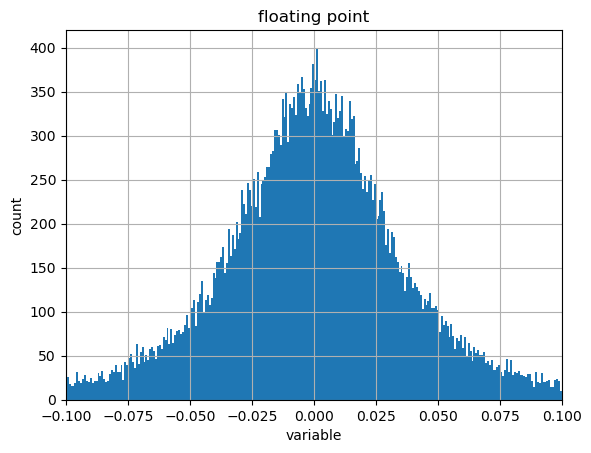

In [34]:
plt.hist(conv2.flatten(), bins=1000)
plt.xlabel("variable")
plt.ylabel("count")
plt.title("floating point")
plt.xlim([-0.1, 0.1])
plt.grid()

## Per-tensor quantization using asymmetric method

**Asymmetric quantization** and **symmetric quantization** are two types of quantization methods used in reducing the precision of neural network weights and activations, often to lower bit-width representations like 8-bit or even 4-bit. These methods are widely used to reduce model size, decrease memory usage, and accelerate inference. Here's a detailed comparison of the two:

### 1. Symmetric Quantization

- **Definition**: In symmetric quantization, both the positive and negative values of a tensor are quantized around a center point of zero, using the same scale factor for the positive and negative ranges.
- **Formula**:
  - Quantized Value: 
    
    $q = \text{round}\left(\frac{x}{s}\right)$
    
    Where \(x\) is the original value, and \(s\) is the scaling factor.
- **Scale Factor**: The scale factor \(s\) is calculated from the absolute maximum value of the original data:
  - $s = \frac{2^{b-1} - 1}{\text{max}(|x|)}$
  - Here, \(b\) is the bit-width (e.g., 8 bits).
- **Range**: Since it is symmetric, the quantization range is \([$-2^{b-1}$, $2^{b-1}-1$]\), meaning the negative and positive ranges are equal in size.
- **Use Cases**: This method works best for tensors whose values are evenly distributed around zero. It is often used for weight quantization, as weights in neural networks are typically centered around zero.

- **Pros**:
  - Simple to implement because it uses a single scaling factor for both positive and negative values.
  - Works well when the data has a symmetric distribution.

- **Cons**:
  - When the data is highly skewed (e.g., has many positive values and very few negative ones), using the same scaling factor for both sides leads to inefficiencies and loss of precision.
  
### 2. Asymmetric Quantization

- **Definition**: In asymmetric quantization, the range is not centered around zero, and different scale and offset values are used to map the original range of data to the quantized values.
- **Formula**:
  - Quantized Value: 
    $q = \text{round}\left(\frac{x - z}{s}\right)$
    Where \(x\) is the original value, \(s\) is the scaling factor, and \(z\) is the zero-point offset.
- **Scale Factor and Zero-Point**:
  - \( s \) is calculated as:
    $s = \frac{\text{max}(x) - \text{min}(x)}{2^b - 1}$
  - The **zero-point** \(z\) is used to shift the range of the data and can be any value within the quantized range to minimize quantization error. Typically, \(z\) is chosen to ensure that zero in the original range is exactly represented in the quantized range.
- **Range**: The quantization range is \([0, 2^b - 1]\) and uses an offset \(z\) to map the input values accordingly.
- **Use Cases**: This method is used for activations, where the range can vary, and it is not always symmetric around zero (e.g., values could range from \(0\) to some positive number).

- **Pros**:
  - Better representation of data when the distribution is not symmetric.
  - Reduces quantization error, especially for activations with non-zero-centered distributions.

- **Cons**:
  - Slightly more complex due to the need for both scaling and zero-point offset.
  - Requires additional computations to handle different scale and zero-point values during quantization and dequantization.

### Comparison Summary

| Feature                   | Symmetric Quantization                    | Asymmetric Quantization                    |
|---------------------------|-------------------------------------------|--------------------------------------------|
| **Scaling Factor**        | Single scaling factor, symmetric around 0 | Separate scaling factor with an offset     |
| **Zero-Point Offset**     | None (always 0)                           | Non-zero offset to handle non-centered data|
| **Range**                 | \([$-2^{b-1}$, $2^{b-1}-1$]\)                 | \([0, $2^b - 1$]\) with an offset             |
| **Best Use Case**         | Weights (usually zero-centered)           | Activations (not always zero-centered)     |
| **Complexity**            | Simple                                    | More complex due to zero-point calculation |
| **Efficiency**            | Efficient for symmetric distributions    | Better for reducing quantization error in non-symmetric distributions |

### Practical Application in Neural Networks
- **Weights Quantization**: Since weights in neural networks often have a mean close to zero and are more or less evenly distributed, **symmetric quantization** is generally used.
- **Activation Quantization**: Activations, such as ReLU outputs, have a range starting from zero and extending into positive values. Hence, **asymmetric quantization** is usually preferred for activations to minimize quantization errors.

### Conclusion
- **Symmetric quantization** is simpler and works well for data with symmetric distributions, while **asymmetric quantization** is better for data with non-zero-centered distributions as it offers a finer level of representation for skewed data. Choosing between the two depends on the specific characteristics of the tensor being quantized.

In [53]:
n_bit = 8
qrange = 2**n_bit

threshold = np.max(conv2) - np.min(conv2)
step = threshold / qrange  # scaling factor

print(
    f"""
    qrange: {qrange}
    threshold: {threshold}
    scaling factor: {step}
    """
)

# quantize with 8 bit
print("before quantization: ", conv2[0][0][0])
q_data = np.round(conv2 / step)
print("after quantization: ", q_data[0][0][0])

# dequantize q_data to be a fixed point number
deq_data = q_data * step
print("dequantization: ", deq_data[0][0][0])

# compare number of unique values count
print(len(np.unique(conv2)), len(np.unique(deq_data)))

# get norm 1 & norm 2 difference
print(norm1_diff(conv2, deq_data), norm2_diff(conv2, deq_data))


    qrange: 256
    threshold: 0.7734677791595459
    scaling factor: 0.003021358512341976
    
before quantization:  [ 0.02594677 -0.10457563 -0.00477124]
after quantization:  [  9. -35.  -2.]
dequantization:  [ 0.02719223 -0.10574755 -0.00604272]
36852 183
27.903473 0.16780086


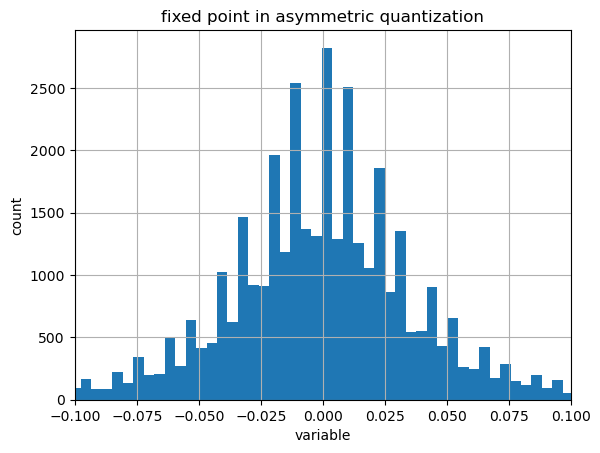

In [51]:
plt.hist(deq_data.flatten(), bins=len(np.unique(deq_data)))
plt.xlabel("variable")
plt.ylabel("count")
plt.title("fixed point in asymmetric quantization")
plt.xlim([-0.1, 0.1])
plt.grid()